In [ ]:
!pip -q install mplfinance plotly ta scikit-learn scipy python-pptx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
from scipy.signal import find_peaks
from sklearn.linear_model import TheilSenRegressor
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,6)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
up = files.upload()  # browse and pick StockDataHDFCBANK.csv


Saving StockDataHDFCBANK.csv to StockDataHDFCBANK.csv


In [ ]:
# Load CSV (works for either 2A or 2B)
df_raw = pd.read_csv("StockDataHDFCBANK.csv")

# Try to standardize column names
df = df_raw.copy()
df.columns = [c.strip() for c in df.columns]

def find_col(possible_names):
    for name in df.columns:
        if name.lower() in [p.lower() for p in possible_names]:
            return name
    raise ValueError(f"Could not find any of {possible_names} in columns: {list(df.columns)}")

date_col = find_col(["date", "timestamp", "datetime"])
open_col = find_col(["open", "Open"])
high_col = find_col(["high", "High"])
low_col  = find_col(["low", "Low"])
close_col= find_col(["close", "Close", "closing_price", "adj close", "Adj Close", "close*"])
vol_col  = None
try:
    vol_col = find_col(["volume","Volume","vol"])
except:
    pass  # volume may not be present

# Parse dates, sort, set index
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])
df = df.sort_values(date_col).reset_index(drop=True)
df = df.set_index(date_col)

# Keep only the essentials in a clean frame
cols = [open_col, high_col, low_col, close_col] + ([vol_col] if vol_col else [])
df = df[cols].rename(columns={
    open_col:"Open", high_col:"High", low_col:"Low", close_col:"Close", **({vol_col:"Volume"} if vol_col else {})
})
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2023-04-03 09:15:00+05:30,1607.55,1609.55,1606.00,1606.65,169821
2023-04-03 09:20:00+05:30,1606.55,1607.95,1603.40,1607.25,203608
2023-04-03 09:25:00+05:30,1607.45,1607.65,1604.10,1607.00,164006
2023-04-03 09:30:00+05:30,1607.00,1610.15,1606.70,1609.10,226137
2023-04-03 09:35:00+05:30,1609.40,1610.40,1607.65,1608.25,138182


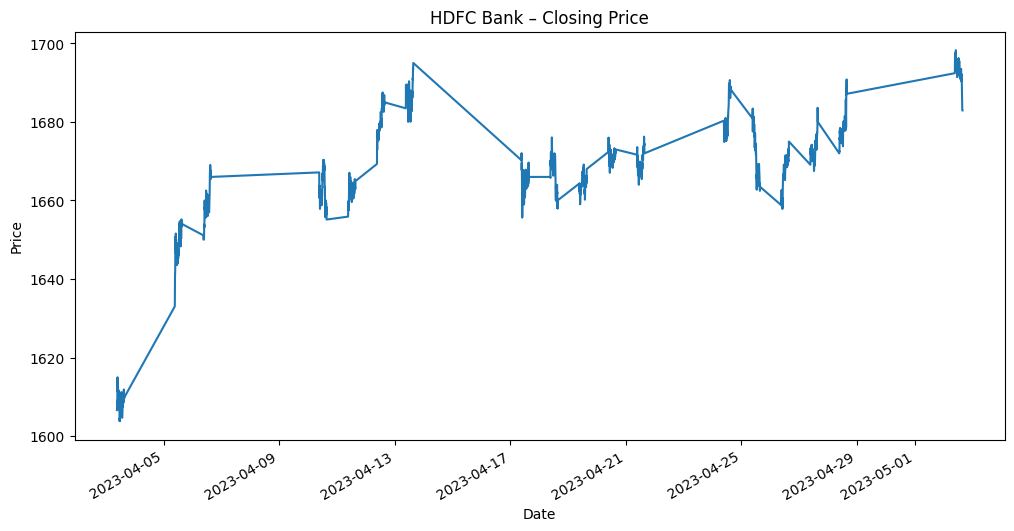

In [ ]:
ax = df["Close"].plot(title="HDFC Bank – Closing Price")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()


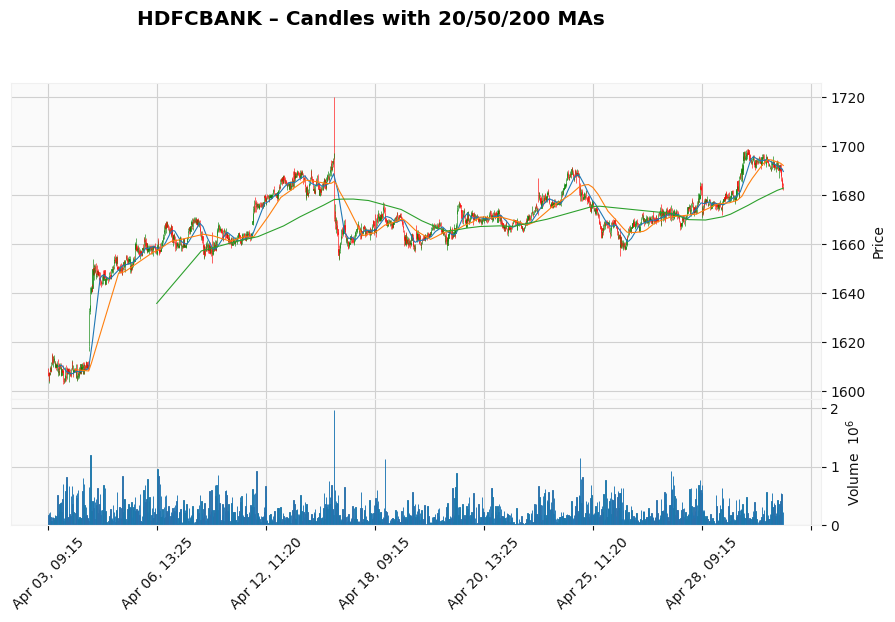

In [ ]:
mc = mpf.make_marketcolors(up='g', down='r', edge='inherit', wick='inherit', volume='in')
style = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

mpf.plot(
    df, type='candle', mav=(20,50,200), volume=vol_col is not None,
    title="HDFCBANK – Candles with 20/50/200 MAs",
    style=style, figratio=(16,9), figscale=1.1
)


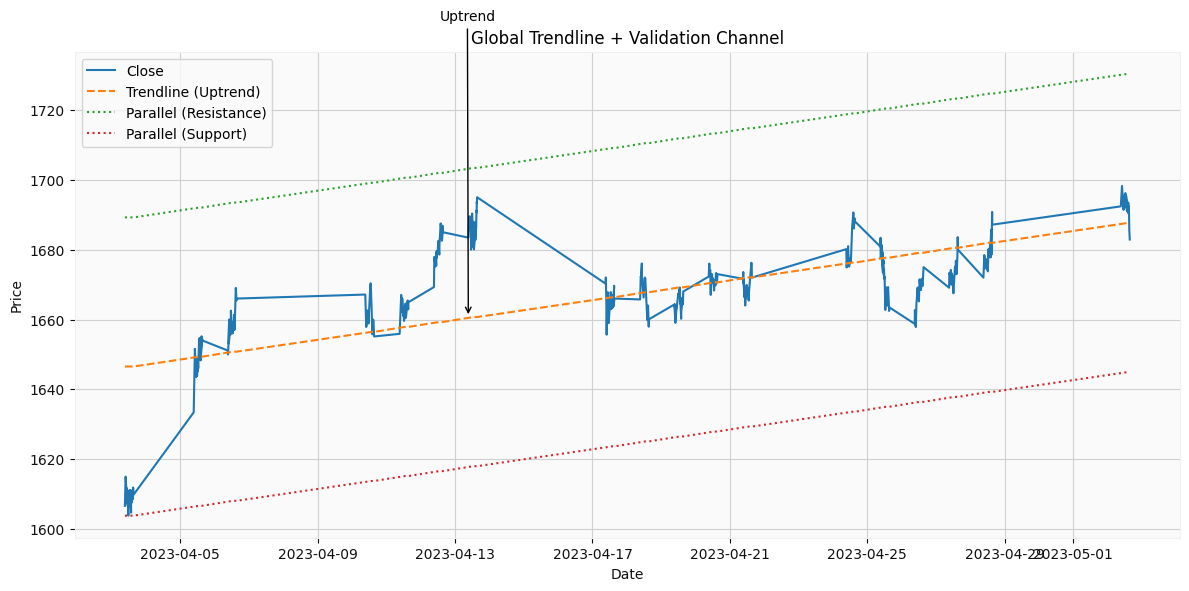

In [ ]:
# Numeric x for regression
x = (df.index - df.index[0]).days.values.astype(float)
y = df["Close"].values

# Ordinary least squares (global trend)
coef = np.polyfit(x, y, 1)            # slope, intercept
trend = np.polyval(coef, x)
resid = y - trend
offset = np.abs(resid).max()          # channel width so it touches highest/lowest point
upper_trend = trend + offset
lower_trend = trend - offset

slope = coef[0]
trend_type = "Uptrend" if slope > 0 else ("Downtrend" if slope < 0 else "Sideways")

# Plot
plt.figure(figsize=(12,6))
plt.plot(df.index, y, label="Close")
plt.plot(df.index, trend, '--', label=f"Trendline ({trend_type})")
plt.plot(df.index, upper_trend, ':', label="Parallel (Resistance)")
plt.plot(df.index, lower_trend, ':', label="Parallel (Support)")

# Annotate
ix = len(df)//3
plt.annotate(trend_type, xy=(df.index[ix], trend[ix]),
             xytext=(df.index[max(ix-30,0)], trend[ix]+(0.05*y.max())),
             arrowprops=dict(arrowstyle="->"))

plt.title("Global Trendline + Validation Channel")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.tight_layout(); plt.show()


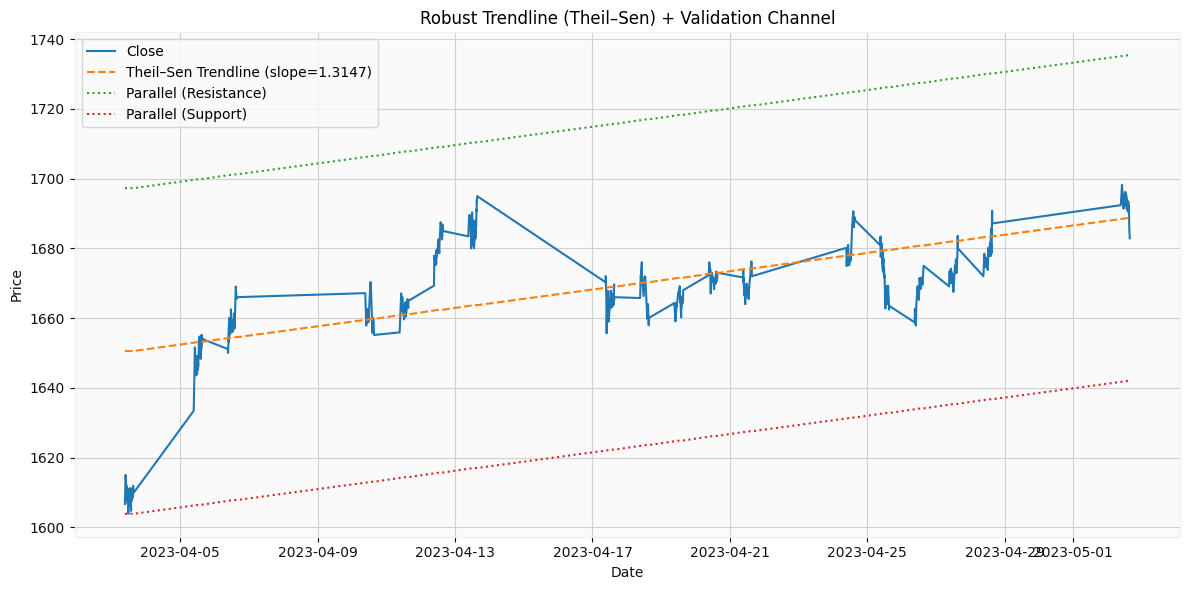

In [ ]:
X = x.reshape(-1,1)
ts = TheilSenRegressor(random_state=42).fit(X, y)
trend_ts = ts.predict(X)
resid_ts = y - trend_ts
off_ts = np.abs(resid_ts).max()

plt.figure(figsize=(12,6))
plt.plot(df.index, y, label="Close")
plt.plot(df.index, trend_ts, '--', label=f"Theil–Sen Trendline (slope={ts.coef_[0]:.4f})")
plt.plot(df.index, trend_ts+off_ts, ':', label="Parallel (Resistance)")
plt.plot(df.index, trend_ts-off_ts, ':', label="Parallel (Support)")
plt.title("Robust Trendline (Theil–Sen) + Validation Channel")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.tight_layout(); plt.show()


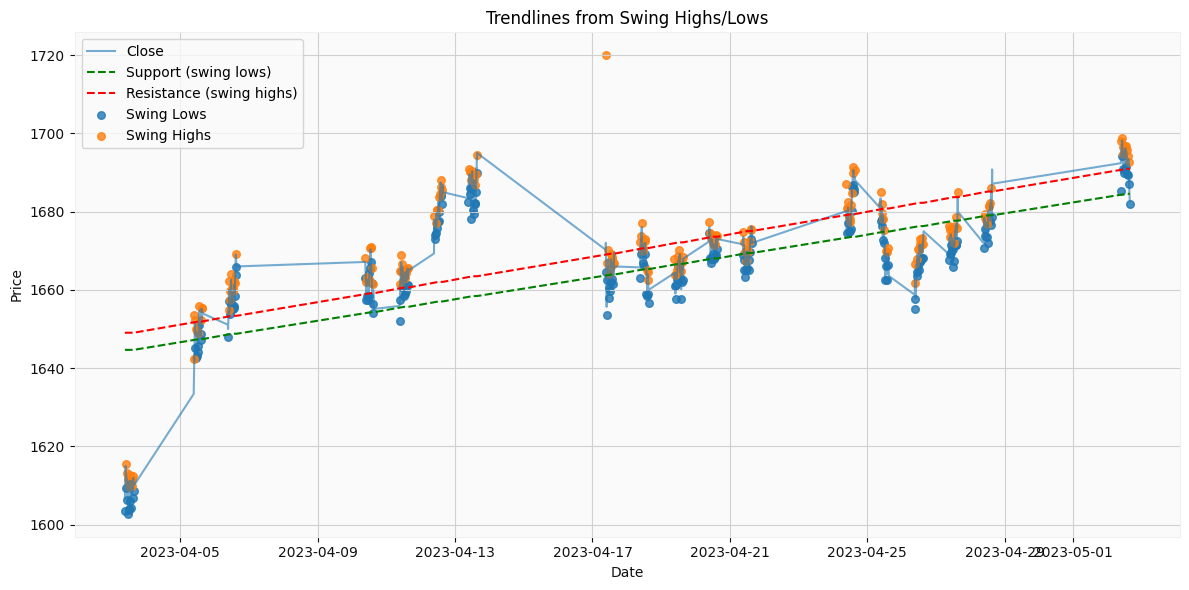

In [ ]:
# Find swing points (tune 'distance' to filter noise)
peak_idx, _   = find_peaks(df["High"].values, distance=5)
trough_idx, _ = find_peaks(-df["Low"].values, distance=5)

# Fit lines through swing highs and lows (if enough points)
def fit_line(indices, yvalues, label):
    if len(indices) < 2:
        return None, None, None
    xp = x[indices]
    yp = yvalues[indices]
    c = np.polyfit(xp, yp, 1)
    line = np.polyval(c, x)
    return c, line, label

c_sup, sup_line, _ = fit_line(trough_idx, df["Low"].values, "Support (from higher lows)")
c_res, res_line, _ = fit_line(peak_idx, df["High"].values, "Resistance (from lower highs)")

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Close", alpha=0.6)
if sup_line is not None:
    plt.plot(df.index, sup_line, 'g--', label="Support (swing lows)")
if res_line is not None:
    plt.plot(df.index, res_line, 'r--', label="Resistance (swing highs)")

plt.scatter(df.index[trough_idx], df["Low"].iloc[trough_idx], s=30, label="Swing Lows", alpha=0.8)
plt.scatter(df.index[peak_idx], df["High"].iloc[peak_idx], s=30, label="Swing Highs", alpha=0.8)

plt.title("Trendlines from Swing Highs/Lows")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.tight_layout(); plt.show()


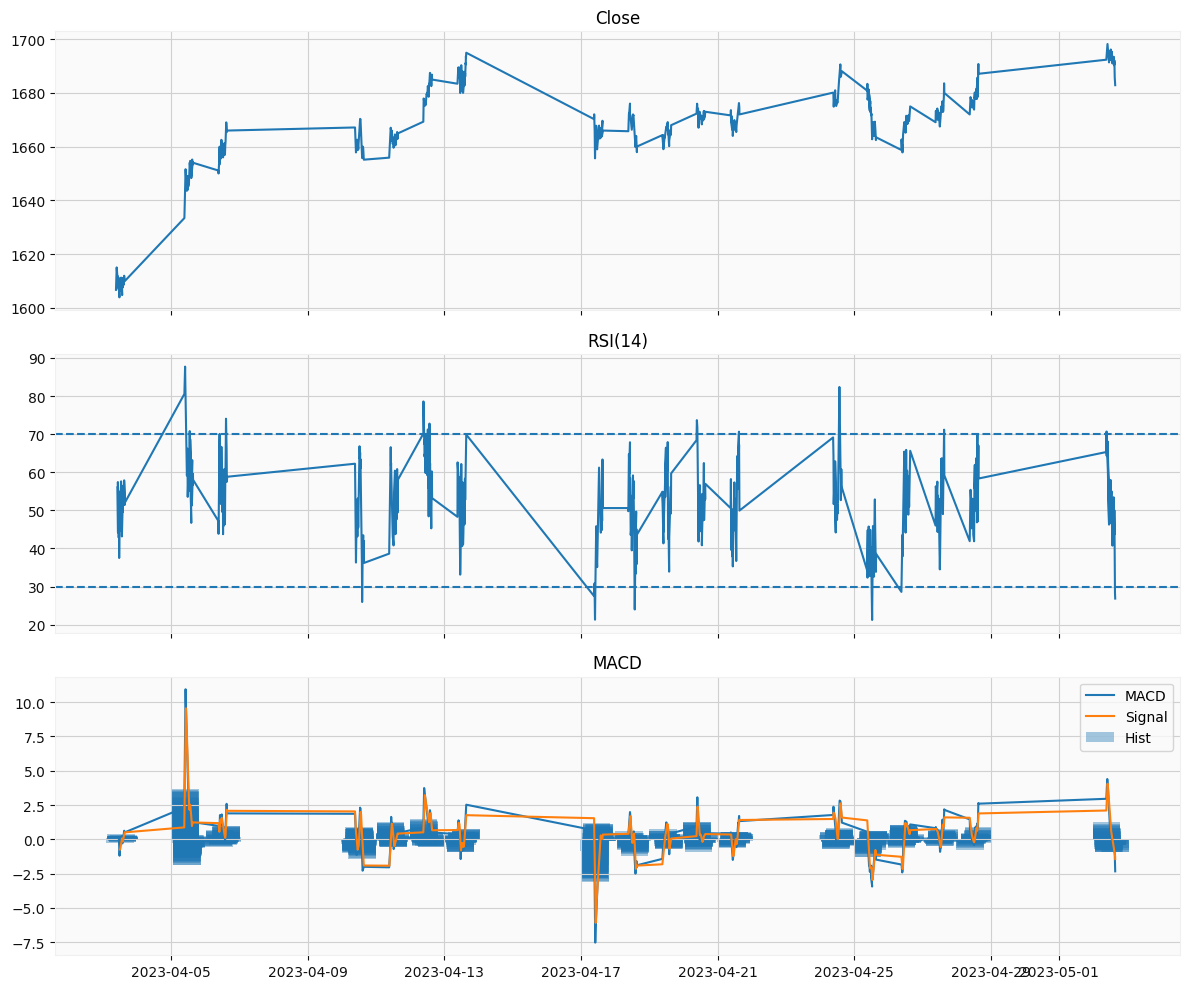

In [ ]:
# RSI & MACD via 'ta' library
from ta.momentum import RSIIndicator
from ta.trend import MACD

rsi = RSIIndicator(close=df["Close"], window=14)
df["RSI14"] = rsi.rsi()

macd = MACD(close=df["Close"], window_slow=26, window_fast=12, window_sign=9)
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()
df["MACD_Hist"] = macd.macd_diff()

# Quick plots
fig, axes = plt.subplots(3, 1, figsize=(12,10), sharex=True)
axes[0].plot(df.index, df["Close"]); axes[0].set_title("Close")
axes[1].plot(df.index, df["RSI14"]); axes[1].axhline(70, ls="--"); axes[1].axhline(30, ls="--"); axes[1].set_title("RSI(14)")
axes[2].plot(df.index, df["MACD"], label="MACD"); axes[2].plot(df.index, df["MACD_Signal"], label="Signal"); axes[2].bar(df.index, df["MACD_Hist"], alpha=0.4, label="Hist")
axes[2].legend(); axes[2].set_title("MACD")
plt.tight_layout(); plt.show()


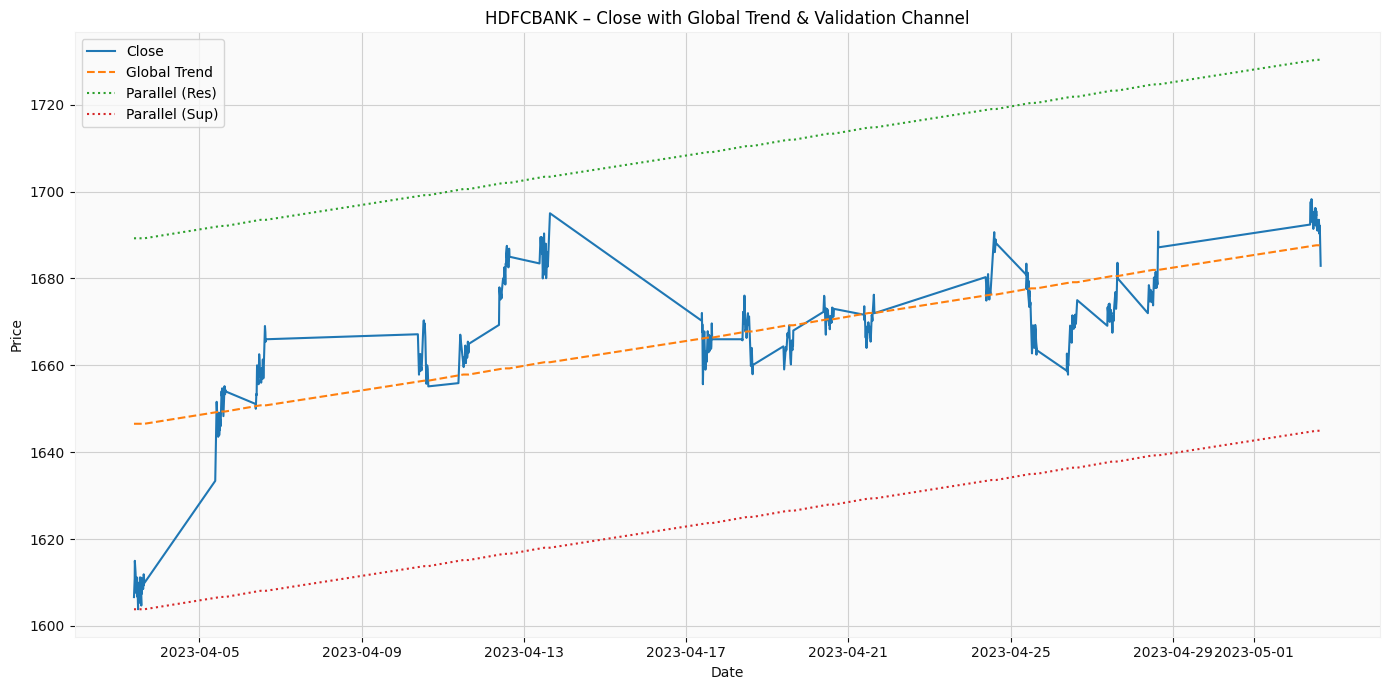

In [ ]:
# Example: replot a key figure and save
plt.figure(figsize=(14,7))
plt.plot(df.index, df["Close"], label="Close")
plt.plot(df.index, trend, '--', label="Global Trend")
plt.plot(df.index, upper_trend, ':', label="Parallel (Res)")
plt.plot(df.index, lower_trend, ':', label="Parallel (Sup)")
plt.title("HDFCBANK – Close with Global Trend & Validation Channel")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.tight_layout()
plt.savefig("hdfc_trend_channel.png", dpi=220)
plt.show()

# Save structural trend fig too (rerun cell 9 plotting into a file if you like)


 📊 Summary

* The HDFC Bank stock data was analyzed using **closing prices, candlestick charts, and trend lines**.
* **Global trend lines** (linear regression) captured the overall price direction.
* **Validation channels** (parallel support and resistance lines) confirmed the reliability of the observed trends.
* **Robust Theil–Sen regression** reduced the effect of outliers, giving a clearer view of long-term direction.
* **Swing high/low trendlines** highlighted structural support and resistance levels.
* Advanced static visualizations (mplfinance candlesticks with moving averages, RSI, MACD) provided insight into **price momentum, volatility, and market strength**.
* Final insight: HDFC Bank stock exhibits phases of **uptrend, consolidation, and corrections**, which can be identified and validated through trend line analysis.